# ベイズ線形回帰の可視化例 (PRML sec. 3.3)

<div style="text-align: right;">
    <a href="prml3.3.ipynb">このページのオリジナルのipynbファイル</a>
</div>

https://qiita.com/ctgk/items/555802600638f41b40c5

をもとに、目的変数の分布が、予測値（回帰式による値）の周りでガウシアンとなっているような場合のベイズ回帰を行い、予測値と確率分布の偏差を描画するプログラムを紹介する。

改変は最小限であるので、基底の数やサンプル数を変えて試してみてほしい。

（PRML 3.3節参照）

トレーニングデータからガウシアン予測分布を算出する式は、[前項](BayesApproach.html)の(4)～(7)式で与えられる。（以下に再掲）

$$
p(t|x, {\bf x},{\bf t}) = \mathcal{N}(t| m(x), s^2(x)) \tag{5}
$$

$$
m(x) = {\bf m}_N^T \phi (x) = \beta \phi (x)^T {\bf S} \sum_{n=1}^N \phi (x_n) t_n \tag{6}
$$
$$
s^2(x) = \beta^{-1} + \phi (x)^T {\bf S}\phi (x) \tag{7}
$$

上記の式に含まれる${\bf w}$の事後分布の平均と分散は
$$
{\bf m}_N = \beta {\bf S}_N {\bf \Phi}^T {\bf t},\quad
{\bf S}_N = (\alpha {\bf I} + \beta {\bf \Phi}^T {\bf \Phi})^{-1} \tag{4} 
$$
である。

$\alpha$, $\beta$はモデルに外から与えるパラメータである。$\alpha$は、なにもデータが得られてない段階の${\bf w}$の確率の分散、$\beta$は目的変数の分散（これは観測者にとってはわからない）を表す。



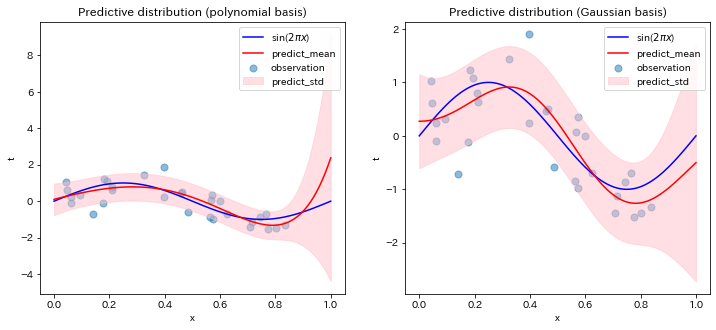

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Polynomial basis
class PolynomialFeatures(object):
    """
    基底関数を多項式(次数：degree)とし、計画行列を作成する
    transform: 引数：  トレーニング用の説明変数データを与える
               返り値： 計画行列
        
    """
    def __init__(self, degree):
        self.degree = degree

    def transform(self, x):
        features = [x ** i for i in range(self.degree + 1)]
        return np.array(features).transpose()

# Gaussian basis
class GaussianFeatures():
    """
    基底関数をガウシアンとして計画行列を作成する
    範囲 [0,1.01] をdegree等分して、それらをガウシアンの中心（平均）とする
    mu: 平均 S: 標準偏差
    
    transform: 引数:  トレーニング用の説明変数データ
               返り値： 計画行列
    
    """
    def __init__(self, degree):
        self.degree = degree
        self.mu = np.linspace(0, 1.01, degree)
        self.S = (self.mu[1] - self.mu[0])*2.0 # muの刻み幅よりは大きくしたい

    def gaussian_basis_func(self, x, i):
        return np.exp(-(x - self.mu[i])**2 / (2 * self.S**2))

    def transform(self, x):
        features = [[self.gaussian_basis_func(x1, i) for i in range(self.degree)] for x1 in x]
        return np.array(features)


class BayesianRegression(object):
    """
    ベイズ回帰 (PRML3.3節に述べられているアルゴリズム)
    fit:     トレーニング（X：説明変数データ, t:目的変数データ）
          前項の(4)式により事後分布の分散と平均を計算
    predict: 予測 (X: 説明変数データ, 返り値: 予測値と標準偏差)
          fitにより求めた、平均値と分散より、予測値（平均値）と標準偏差（誤差範囲）を計算
    """
    def __init__(self, alpha=0.1, beta=0.25):
        self.alpha = alpha
        self.beta = beta

    def fit(self, X, t):
        # 上記(4)式
        self.w_var = np.linalg.inv(
            self.alpha * np.identity(np.size(X, 1))
            + self.beta * X.T.dot(X)) 
        # (6)式のm_Nの計算
        self.w_mean = self.beta * self.w_var.dot(X.T.dot(t))

    def predict(self, X):
        y = X.dot(self.w_mean) # (6)式の計算
        y_var = 1 / self.beta + np.sum(X.dot(self.w_var) * X, axis=1) # (7)式の計算
        y_std = np.sqrt(y_var)
        return y, y_std


def create_toy_data(func, low=0, high=1, size=10, sigma=1.):
    """
    サンプルデータ作成用の関数
      [low, high]の範囲をsize等分し、説明変数とする
      説明変数の値をfunc関数で計算し、
      それにガウシアンノイズを乗せて目的変数の値を計算し、返す
    """
    x = np.random.uniform(low, high, size)
    t = func(x) + np.random.normal(scale=sigma, size=size)
    return x, t

def main(x, t, features = None, ax = None, title=""): # メインルーチン
    """
    引数で与えられた基底（オブジェクト）でのベイズ回帰分布を求め、
    テスト用説明変数(下記x_test)に対する予測値と誤差範囲を描画する
    　・feature=Noneならば、ガウシアン基底とする
      ・featureオブジェクトクラスは事前に作っておく
        (PolynomialFeature、GaussianFeatureは上で用意)
    """

    if ax == None:
        fig = plt.figure(figsize=(6, 4))
        ax = fig.add_subplot(1,1,1)
    
    ax.scatter(x, t, s=50, marker='o', alpha=0.5, label="observation")
  
    # features = PolynomialFeatures(degree=num_basis) # 多項式基底
    if features == None:
        features = GaussianFeatures(degree=num_basis)    # ガウシアン基底
    X = features.transform(x) # 計画行列をつくる
    
    regression = BayesianRegression(alpha=1e-3, beta=2) # 回帰クラスオブジェクト生成
    regression.fit(X, t) # 回帰

    x_test = np.linspace(0, 1, 100)
    X_test = features.transform(x_test)
    y, y_std = regression.predict(X_test)

    ax.plot(x_test, func(x_test), color='blue', label="sin($2\pi x$)")
    ax.plot(x_test, y, color='red', label="predict_mean")
    ax.fill_between(x_test, y - y_std, y + y_std,
                     color='pink', alpha=0.5, label="predict_std")
    ax.legend()
    ax.set_title("Predictive distribution " + title)
    ax.set_xlabel("x")
    ax.set_ylabel("t")
    #plt.show()


if __name__ == '__main__':

    def func(x):
        return np.sin(2 * np.pi * x)
    # サンプルデータ作成
    num_data = 30
    x, t = create_toy_data(func, low=0, high=1, size=num_data, sigma=0.5)

    # 描画準備
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    
    # ベイズ回帰
    num_basis=8
    poly_features = PolynomialFeatures(degree=num_basis) # 多項式基底
    main(x, t, features=poly_features, ax=ax[0], title="(polynomial basis)")
    
    gauss_features =GaussianFeatures(degree=num_basis) # ガウシアン基底
    main(x, t, features=gauss_features, ax=ax[1], title="(Gaussian basis)")
    

演習補足：

121行目からのfunc()がサンプルデータ作成のベースとなる関数である。この関数やデータ数(num_data)、付加ランダム項の分散(sigma)などを変えてテストしてみよう。


学習データが周期関数($\sin$)なので、べき多項式へのフィッティングでは範囲の右端では無理が生じていることがわかる。ガウシアンの方がその点ではまさる。

## 参考：基底関数の図 (PRML Fig. 3.1)

多項式
<img src="http://8tops.yamanashi.ac.jp/~toyoki/lectures/simulationMethods/images/prmlfigs-png/Figure3.1a.png" width="300"/>
ガウシアン
<img src="http://8tops.yamanashi.ac.jp/~toyoki/lectures/simulationMethods/images/prmlfigs-png/Figure3.1b.png" width="300"/>
シグモイド
<img src="http://8tops.yamanashi.ac.jp/~toyoki/lectures/simulationMethods/images/prmlfigs-png/Figure3.1c.png" width="300"/>

